# Introduction to Hypergraphs for Program Analysis

## Analyzing Function Composition Order

Some function compositions are commutative (order doesn't matter) while others aren't. Let's analyze examples:

1. Commutative example: `scale_up` and `threshold`
   - `scale_up(threshold(x)) ≡ threshold(scale_up(x))`

2. Non-commutative example: `shift_right` and `local_max`
   - `shift_right(local_max(x)) ≠ local_max(shift_right(x))`

We can use hypergraphs to represent and analyze these relationships.

In [1]:
import numpy as np
import hypernetx as hnx
import matplotlib.pyplot as plt

import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))  # Add parent directory to path

from src.array_transforms import scale_up, threshold, shift_right, local_max

def test_commutativity(f, g, test_arrays):
    """Test if functions f and g commute on test arrays."""
    results = []
    for arr in test_arrays:
        fg = f(g(arr.copy()))
        gf = g(f(arr.copy()))
        results.append(np.array_equal(fg, gf))
    return all(results)

# Generate test arrays
test_arrays = [
    np.array([1, 3, 2, 4, 1, 5, 2, 3]),
    np.array([5, 2, 7, 1, 4, 3, 6, 2]),
    np.array([0, 1, 0, 1, 0, 1, 0, 1])
]

# Test commutativity
scale_threshold_commute = test_commutativity(scale_up, threshold, test_arrays)
shift_local_commute = test_commutativity(shift_right, local_max, test_arrays)

print(f"scale_up ∘ threshold commutes: {scale_threshold_commute}")
print(f"shift_right ∘ local_max commutes: {shift_local_commute}")

# Show example of non-commutativity
arr = test_arrays[0]
print("\nExample of non-commutativity:")
print(f"Original:                    {arr}")
print(f"shift_right(local_max(x)):  {shift_right(local_max(arr.copy()))}")
print(f"local_max(shift_right(x)):  {local_max(shift_right(arr.copy()))}")

scale_up ∘ threshold commutes: False
shift_right ∘ local_max commutes: True

Example of non-commutativity:
Original:                    [1 3 2 4 1 5 2 3]
shift_right(local_max(x)):  [3 3 3 4 4 5 5 5]
local_max(shift_right(x)):  [3 3 3 4 4 5 5 5]


### Representing Order in Hypergraphs

We can represent ordering constraints in hypergraphs using:
1. Directed hyperedges
2. Order-specific edge labels
3. Separate edges for different orderings

Let's create a hypergraph that captures both commutative and non-commutative relationships:

/Users/tylerfarnan/anaconda3/envs/symstrate/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/tylerfarnan/anaconda3/envs/symstrate/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/tylerfarnan/anaconda3/envs/symstrate/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.grou

Text(0.5, 1.0, 'Hypergraph Representation of Function Composition Order')

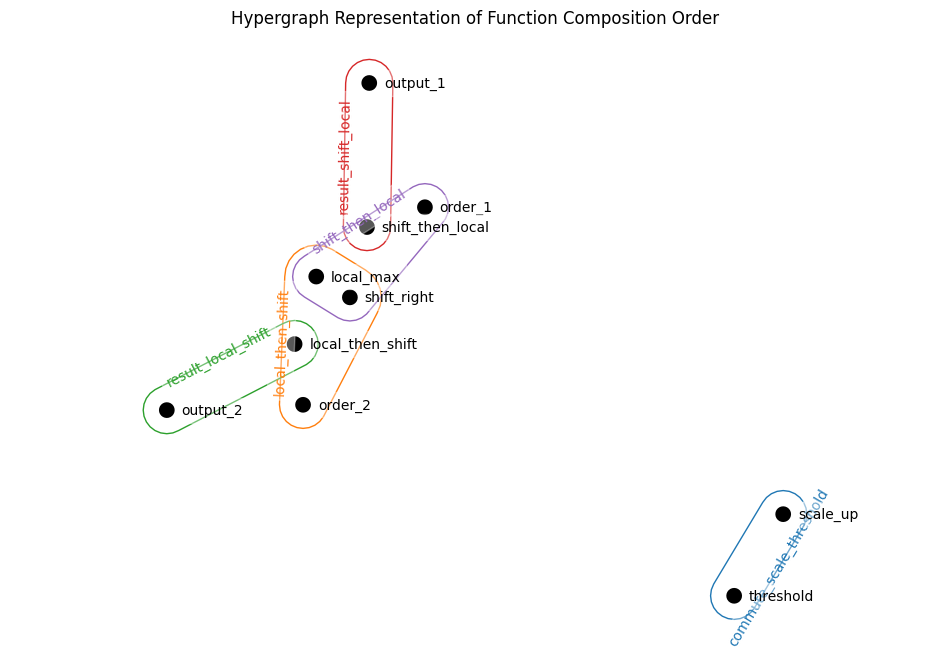

In [2]:
def create_order_hypergraph():
    edges = {
        'commute_scale_threshold': {'scale_up', 'threshold'},
        'shift_then_local': {'shift_right', 'local_max', 'order_1'},
        'local_then_shift': {'shift_right', 'local_max', 'order_2'},
        'result_shift_local': {'shift_then_local', 'output_1'},
        'result_local_shift': {'local_then_shift', 'output_2'}
    }
    return hnx.Hypergraph(edges)

H_order = create_order_hypergraph()

plt.figure(figsize=(12, 8))
hnx.drawing.draw(H_order,
                with_node_labels=True,
                with_edge_labels=True)
plt.title("Hypergraph Representation of Function Composition Order")

### Analyzing Order Dependencies

We can analyze the hypergraph to detect order dependencies:

In [3]:
def analyze_order_dependencies(H):
    function_pairs = set()
    ordered_pairs = set()
    
    for edge in H.edges:
        nodes = list(H.edges[edge])
        if any('order' in str(n) for n in nodes):
            funcs = [n for n in nodes if n not in ['order_1', 'order_2']]
            if len(funcs) == 2:
                ordered_pairs.add(tuple(sorted(funcs)))
        else:
            funcs = [n for n in nodes if not n.startswith('output')]
            if len(funcs) == 2:
                function_pairs.add(tuple(sorted(funcs)))
    
    commutative_pairs = function_pairs - ordered_pairs
    
    return {
        'ordered': ordered_pairs,
        'commutative': commutative_pairs
    }

dependencies = analyze_order_dependencies(H_order)

print("Order Analysis:")
print("\nCommutative function pairs:")
for pair in dependencies['commutative']:
    print(f"  {pair[0]} ∘ {pair[1]}")

print("\nOrder-dependent function pairs:")
for pair in dependencies['ordered']:
    print(f"  {pair[0]} ∘ {pair[1]} ≠ {pair[1]} ∘ {pair[0]}")

Order Analysis:

Commutative function pairs:
  scale_up ∘ threshold

Order-dependent function pairs:
  local_max ∘ shift_right ≠ shift_right ∘ local_max
